In [2]:
from CGS import solve_cgs;
from CGN import solve_cgn;
from scipy.sparse.linalg import qmr;
import matrixgenerators
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# to be ran if stuff doesnt update with algorithms
import importlib
import CGS
import CGN
import matrixgenerators

importlib.reload(CGS)
importlib.reload(CGN)
importlib.reload(matrixgenerators)

from CGS import solve_cgs
from CGN import solve_cgn


First experiment: Calculating how residual error + time taken to run change with matrix size with a fixed condition number.

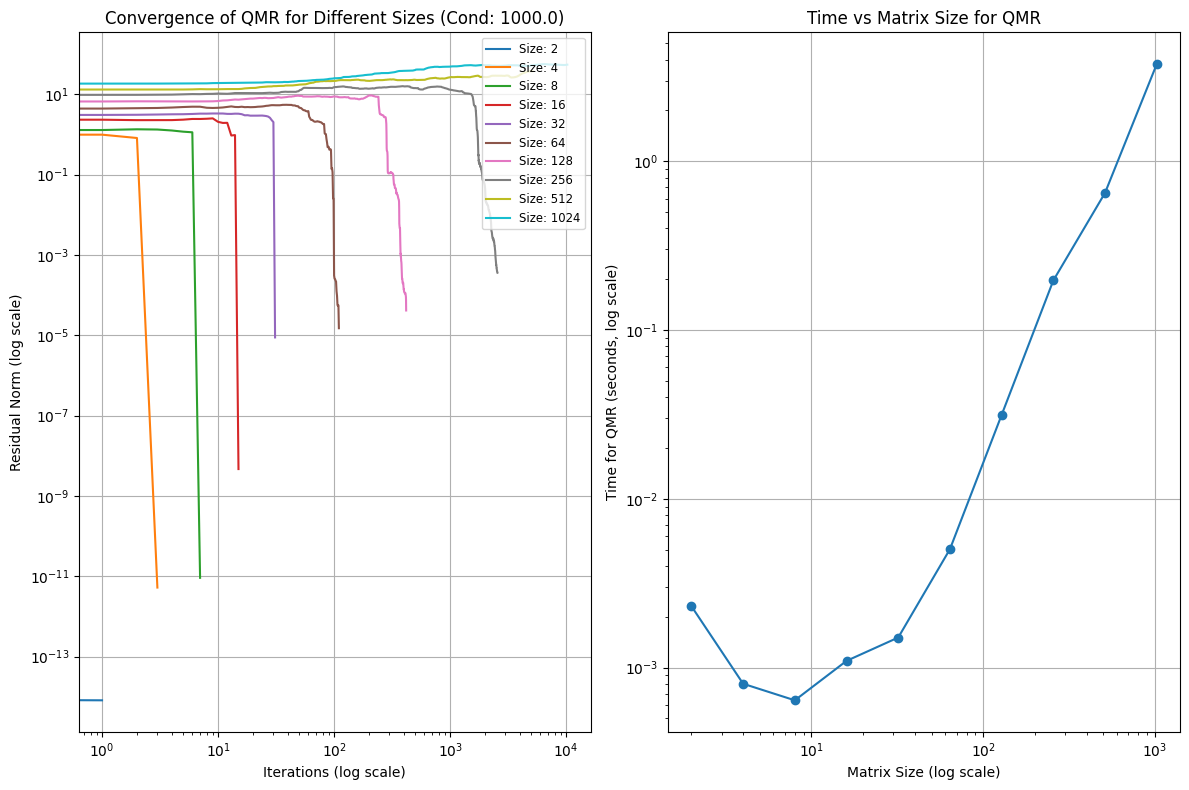

In [3]:
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import qmr

fixed_kappa = 1e3  
sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]  # Matrix sizes

# Store residuals and timings
results_size = {}
timings_size = {}

for dim in sizes:
    b = np.random.rand(dim)  # Random right-hand side vector
    A = matrixgenerators.cond_num_matrix(dim, fixed_kappa)  # Generate matrix with condition number
    
    residuals = []
    
    def callback(xk):
        """Calculate the residual norm for each iteration."""
        r = b - A @ xk
        residuals.append(np.linalg.norm(r))
    
    # Time the execution of qmr
    start_time = time.time()
    solution, exit_code = qmr(A, b, callback=callback)
    end_time = time.time()
    
    # Store results
    results_size[dim] = residuals
    timings_size[dim] = end_time - start_time  # Total time taken for qmr

plt.figure(figsize=(12, 8))

# Subplot 1: Residuals vs iterations
plt.subplot(1, 2, 1)
for dim, residuals in results_size.items():
    plt.plot(residuals, label=f"Size: {dim}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations (log scale)")
plt.ylabel("Residual Norm (log scale)")
plt.title(f"Convergence of QMR for Different Sizes (Cond: {fixed_kappa})")
plt.legend(loc="upper right", fontsize="small")
plt.grid()

# Subplot 2: Timing vs matrix size
plt.subplot(1, 2, 2)
plt.plot(timings_size.keys(), timings_size.values(), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time for QMR (seconds, log scale)")
plt.title("Time vs Matrix Size for QMR")
plt.grid()

plt.tight_layout()
plt.show()


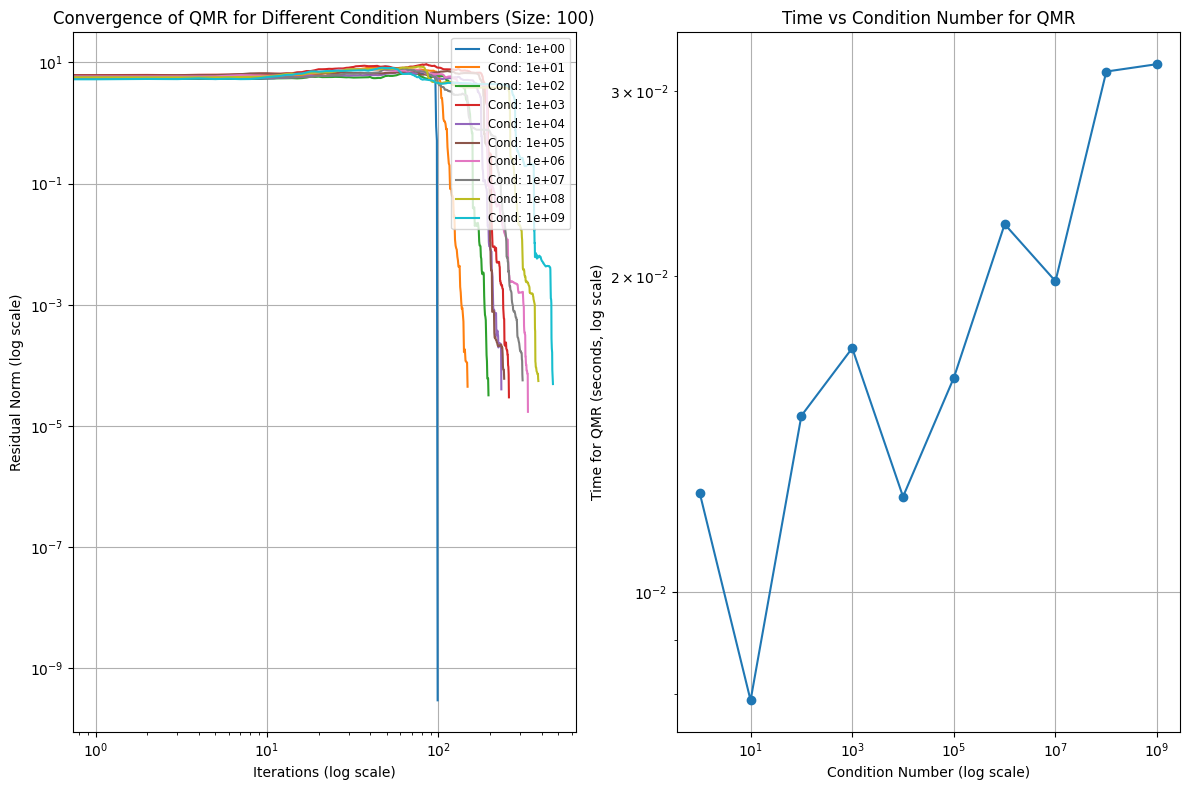

In [5]:
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import qmr

# Fixed matrix size
fixed_size = 100  # Fixed size for the experiment
condition_numbers = [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]  # Condition numbers to test

# Store residuals and timings
results_condition = {}
timings_condition = {}

for kappa in condition_numbers:
    b = np.random.rand(fixed_size)  # Random right-hand side vector
    A = matrixgenerators.cond_num_matrix(fixed_size, kappa) * 10  # Generate matrix with condition number
    
    residuals = []
    
    def callback(xk):
        """Track the residual norm at each iteration."""
        r = b - A @ xk
        residuals.append(np.linalg.norm(r))
    
    # Time the QMR execution
    start_time = time.time()
    solution, exit_code = qmr(A, b, callback=callback)
    end_time = time.time()
    
    # Store results
    results_condition[kappa] = residuals
    timings_condition[kappa] = end_time - start_time

# Plot results
plt.figure(figsize=(12, 8))

# Subplot 1: Residuals vs iterations
plt.subplot(1, 2, 1)
for kappa, residuals in results_condition.items():
    plt.plot(residuals, label=f"Cond: {kappa:.0e}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations (log scale)")
plt.ylabel("Residual Norm (log scale)")
plt.title(f"Convergence of QMR for Different Condition Numbers (Size: {fixed_size})")
plt.legend(loc="upper right", fontsize="small")
plt.grid()

# Subplot 2: Timing vs condition number
plt.subplot(1, 2, 2)
plt.plot(timings_condition.keys(), timings_condition.values(), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Condition Number (log scale)")
plt.ylabel("Time for QMR (seconds, log scale)")
plt.title("Time vs Condition Number for QMR")
plt.grid()

plt.tight_layout()
plt.show()


Now we are going to examine how sparsity impacts convergence, fixing size but not condition number (cause sparsity will change condition number anyway and random matrices should not have too variable CN).

Sparsity: 0.0, Condition Number: 6.64e+02
Sparsity: 0.1, Condition Number: 2.65e+02
Sparsity: 0.3, Condition Number: 1.21e+03
Sparsity: 0.5, Condition Number: 3.05e+02
Sparsity: 0.7, Condition Number: 7.98e+01
Sparsity: 0.9, Condition Number: 8.11e+18


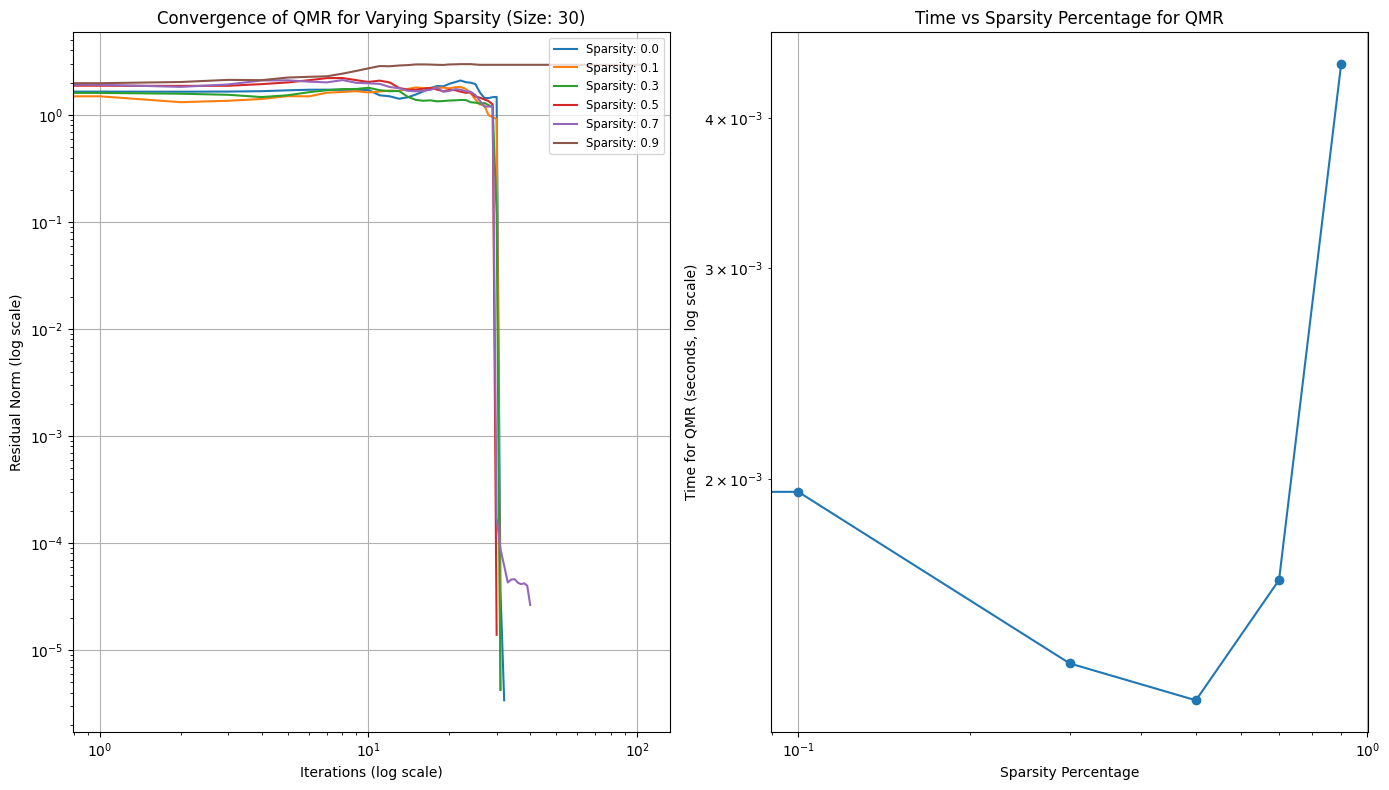

In [4]:
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import qmr

# Experiment parameters
fixed_size = 30  # Fixed matrix size
sparsity_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Sparsity percentages (0 = dense, 0.9 = very sparse)

# Store results
results_sparsity = {}
timings_sparsity = {}
condition_numbers = {}

for sparsity in sparsity_levels:
    # Generate matrix and make it sparse
    dense_matrix = np.random.rand(fixed_size, fixed_size)  # Dense random matrix
    sparse_matrix = matrixgenerators.make_matrix_sparse(dense_matrix, sparsity)
    
    # Calculate and store the condition number of the sparse matrix
    cond_num = np.linalg.cond(sparse_matrix)
    condition_numbers[sparsity] = cond_num
    print(f"Sparsity: {sparsity:.1f}, Condition Number: {cond_num:.2e}")
    
    # Generate random b
    b = np.random.rand(fixed_size)
    
    # Track residuals using a callback
    residuals = []
    
    def callback(xk):
        """Track the residual norm at each iteration."""
        r = b - sparse_matrix @ xk
        residuals.append(np.linalg.norm(r))
    
    # Time QMR solver
    start_time = time.time()
    solution, exit_code = qmr(sparse_matrix, b, callback=callback)
    end_time = time.time()
    
    # Store results
    results_sparsity[sparsity] = residuals
    timings_sparsity[sparsity] = end_time - start_time  # Time taken for QMR call

# Plot results
plt.figure(figsize=(14, 8))

# Subplot 1: Residuals vs iterations for varying sparsity
plt.subplot(1, 2, 1)
for sparsity, residuals in results_sparsity.items():
    plt.plot(residuals, label=f"Sparsity: {sparsity:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations (log scale)")
plt.ylabel("Residual Norm (log scale)")
plt.title(f"Convergence of QMR for Varying Sparsity (Size: {fixed_size})")
plt.legend(loc="upper right", fontsize="small")
plt.grid()

# Subplot 2: Time vs sparsity percentage
plt.subplot(1, 2, 2)
plt.plot(timings_sparsity.keys(), timings_sparsity.values(), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Sparsity Percentage")
plt.ylabel("Time for QMR (seconds, log scale)")
plt.title("Time vs Sparsity Percentage for QMR")
plt.grid()

plt.tight_layout()
plt.show()


Now, I am going to experiment based on eigenvalues. I will experiment both with spectral abscissa and the density of eigenvalues, conducting the same experiment both with clustered eigenvalues and spread ones.

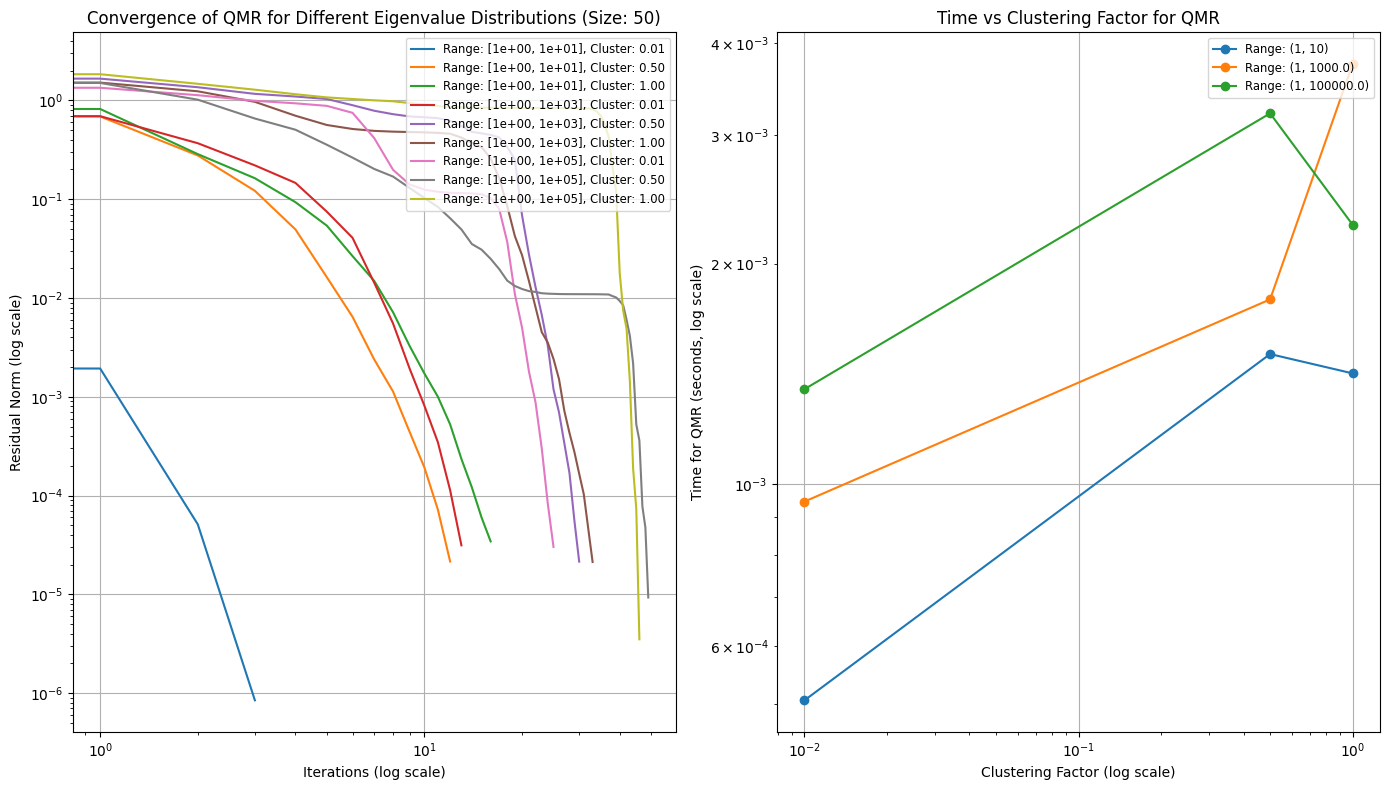

In [7]:
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import qmr

# Experiment parameters
fixed_size = 50  # Matrix size
eigen_ranges = [(1, 10), (1, 1e3), (1, 1e5)]  # Varying spectral ranges
clustering_factors = [0.01, 0.5, 1]  # Controls clustering within ranges

# Store results
results_eigenvalues = {}
timings_eigenvalues = {}

for eigen_min, eigen_max in eigen_ranges:
    for cluster_factor in clustering_factors:
        eigen_min_adj = eigen_min
        eigen_max_adj = eigen_min + cluster_factor * (eigen_max - eigen_min)
        
        # Generate matrix with specified eigenvalue clustering
        matrix, _ = matrixgenerators.generate_eigenvalue_range(fixed_size, eigen_min_adj, eigen_max_adj)
        
        # Generate random b
        b = np.random.rand(fixed_size)
        
        # Track residuals using a callback
        residuals = []
        
        def callback(xk):
            """Track the residual norm at each iteration."""
            r = b - matrix @ xk
            residuals.append(np.linalg.norm(r))
        
        # Time the QMR solver
        start_time = time.time()
        solution, exit_code = qmr(matrix, b, callback=callback)
        end_time = time.time()
        
        # Store results
        key = (eigen_min, eigen_max, cluster_factor)
        results_eigenvalues[key] = residuals
        timings_eigenvalues[key] = end_time - start_time

# Plot results
plt.figure(figsize=(14, 8))

# Subplot 1: Residuals vs iterations for varying eigenvalue distributions
plt.subplot(1, 2, 1)
for key, residuals in results_eigenvalues.items():
    eigen_min, eigen_max, cluster_factor = key
    plt.plot(residuals, label=f"Range: [{eigen_min:.0e}, {eigen_max:.0e}], Cluster: {cluster_factor:.2f}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations (log scale)")
plt.ylabel("Residual Norm (log scale)")
plt.title(f"Convergence of QMR for Different Eigenvalue Distributions (Size: {fixed_size})")
plt.legend(loc="upper right", fontsize="small")
plt.grid()

# Subplot 2: Time vs clustering factor
plt.subplot(1, 2, 2)
for eigen_range in eigen_ranges:
    cluster_times = [timings_eigenvalues[(eigen_range[0], eigen_range[1], cf)] for cf in clustering_factors]
    plt.plot(clustering_factors, cluster_times, marker='o', label=f"Range: {eigen_range}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Clustering Factor (log scale)")
plt.ylabel("Time for QMR (seconds, log scale)")
plt.title("Time vs Clustering Factor for QMR")
plt.legend(loc="upper right", fontsize="small")
plt.grid()

plt.tight_layout()
plt.show()
